# DML Group Project on DETR

In this notebook, we are going to fine-tune and improve [DETR](https://huggingface.co/docs/transformers/model_doc/detr) (end-to-end object detection with Transformers) on a custom object detection dataset. The goal for the model is to detect objects in a custom dataset.

Our framework is based  on this tutorial: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb. Thanks to NielsRogge, the tutorials' creator.

We're going to fine-tune the model using [PyTorch Lightning].


## Create Dataset & Dataloaders

Torchvision already provides a `CocoDetection` dataset, which we can use. NielsRogge only add an image processor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [1]:
import os
import torch
import torchvision
from transformers import AutoImageProcessor, DetrImageProcessor

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "annotations.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target 
        # converting target to DETR format, resizing + normalization of both image and target
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return pixel_values, target

DATA_DIR = './/shipdata'  # to modify

TRAIN_DIR = os.path.join(DATA_DIR, "train")  # Train Data
VAL_DIR = os.path.join(DATA_DIR, "val")  # Validation Data
# TEST_DIR = os.path.join(DATA_DIR, "test")  # Test Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
processor = AutoImageProcessor.from_pretrained("microsoft/conditional-detr-resnet-50")

train_dataset = CocoDetection(img_folder=TRAIN_DIR, processor=processor)
val_dataset = CocoDetection(img_folder=VAL_DIR, processor=processor, train=False)
# test_dataset = CocoDetection(img_folder=TEST_DIR, processor=processor, train=False)

2023-10-23 01:34:28.571548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 01:34:28.571613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 01:34:28.571649: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 01:34:28.581917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not find image processor class in th

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


As you can see, this dataset is tiny. At the beginning, we use a train dataset of 5k images, then each epoch takes about 2 hours. To reduce the time costs of the project, we cut the train dataset to 1.5k images.

In [2]:
print("Number of Training examples:", len(train_dataset))
print("Number of Val           examples:", len(val_dataset))
# print("Number of Test         examples:", len(test_dataset))

Number of Training examples: 1536
Number of Val           examples: 226


Show an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`. 

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

cats = val_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def display_truth(image_id = None):
    image_ids = val_dataset.coco.getImgIds()
    image_id = image_ids[np.random.randint(0, len(image_ids))] if image_id == None else image_id
    print('Image #{} Ground True Objects: '.format(image_id))

    image = val_dataset.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join(VAL_DIR, image['file_name']))

    annotations = val_dataset.coco.imgToAnns[image_id]
    draw = ImageDraw.Draw(image, "RGBA")



    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        box = annotation['bbox']
        class_idx = annotation['category_id']
        x,y,w,h = tuple(box)

        ax.add_patch(plt.Rectangle((x, y), w, h,
                                   fill=False, color='yellow', linewidth=5))
        text = f'{id2label[class_idx]}'
        ax.text(x, y - 10, text, fontsize=25,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

There are large boats as well as very small boat objects in the image:

Image #5 Ground True Objects: 


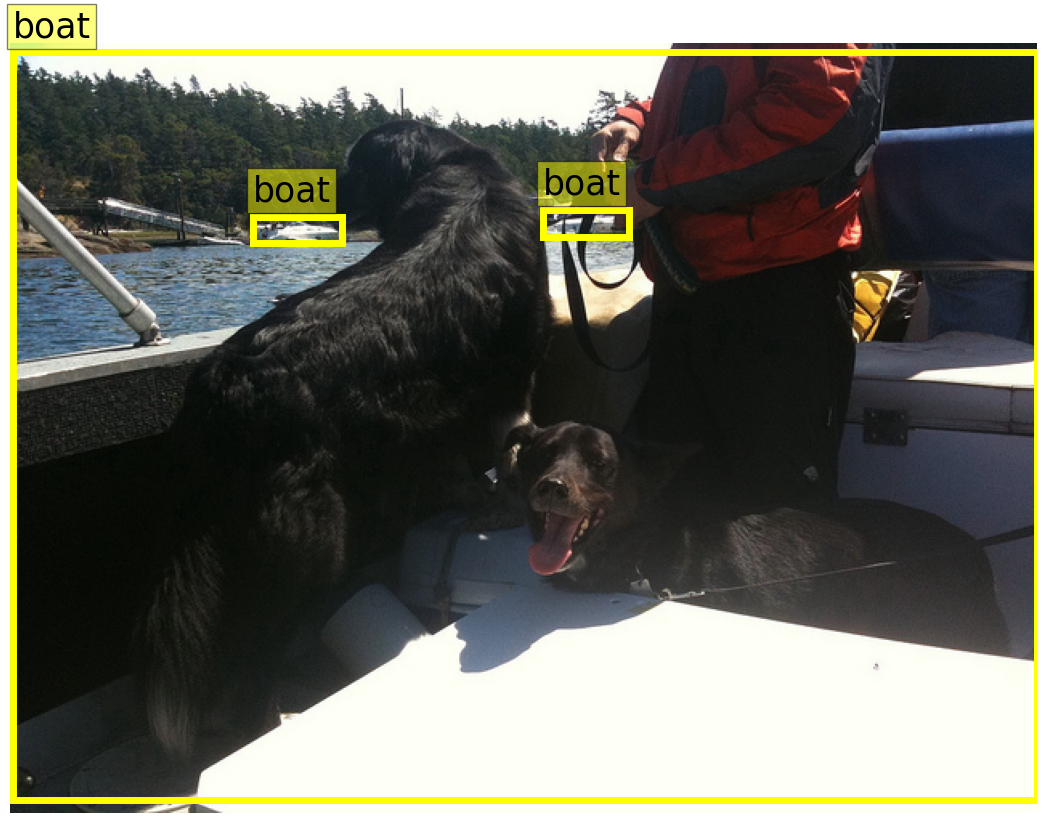

In [4]:
display_truth(5)

Next, let's create corresponding PyTorch dataloaders, which allow us to get batches of data. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

train_batch_size = 4  # batch size for training
val_batch_size = 4  # batch size for validation

train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn,
                              batch_size=train_batch_size,
                              shuffle=True,
                              num_workers=6
                             )
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=val_batch_size, num_workers=6)
batch = next(iter(train_dataloader))

## Train

Train the model using PyTorch Lightning. Here we define a `LightningModule`, which is an `nn.Module` with some extra functionality.

As PyTorch Lightning by default logs to **Tensorboard**, we can open the board and see log data on a local browser.

In [6]:
%load_ext tensorboard
# %tensorboard --logdir ./logs/lightning_logs/

In [7]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay, model = None):
        super().__init__()
        
        self.model = model
        if model == None:
            # we specify the "no_timm" variant here to not rely on the timm library for the convolutional backbone
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm", 
                                                             num_labels=len(id2label),   # replace COCO classification head with a custom classifer based on this dataset
                                                             ignore_mismatched_sizes=True)
       
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay
        self.val_outs = []  # for evaluation

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        return outputs
     
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return outputs, loss, loss_dict

    def training_step(self, batch, batch_idx):
        _, loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())
        
        return loss

    def validation_step(self, batch, batch_idx):
        outputs, loss, loss_dict = self.common_step(batch, batch_idx)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized
        self.val_outs.append((labels, outputs))  # for evaluation
#         print(self.current_epoch, "validation_loss: ", loss)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [8]:
myModel = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
outputs = myModel(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

# freeze backbone and transformer
for name, param in myModel.named_parameters():
    if 'model.model' in name:
        param.requires_grad = False
    print(name, param.requires_grad, param.shape)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.model.backbone.conv_encoder.model.embedder.embedder.convolution.weight False torch.Size([64, 3, 7, 7])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.shortcut.convolution.weight False torch.Size([256, 64, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.0.convolution.weight False torch.Size([64, 64, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.1.convolution.weight False torch.Size([64, 64, 3, 3])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.2.convolution.weight False torch.Size([256, 64, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.0.convolution.weight False torch.Size([64, 256, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.1.convolution.weight False torch.Size([64, 64, 3, 3])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.2.convolution.weight False torch.Size([256, 64, 1, 1])
mode

The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension. 

In [9]:
print(outputs.logits.shape)
print(outputs.keys())

torch.Size([4, 100, 2])
odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


Defines some callback functions to store the training process and results:

In [10]:
## Callback for saving local checkpoints
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    verbose=True,
    every_n_train_steps = 50,
    dirpath="./checkpoints",
#     filename="checkpoint-{epoch}-{step}",
    filename="last"
)

# Callback for  pushing to Hugging Face
class PushToHubCallback(pl.Callback):
    '''
    Callback for  pushing to Hugging Face
    '''
    def __init__(self, model_name):
        self.name = model_name
    
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model {self.name} to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("cheaple/my-detr",
                                    commit_message=f"{self.name} -- training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model {self.name} to the hub after training")
        pl_module.model.push_to_hub("cheaple/my-detr",
                                    commit_message=f"{self.name} -- training done")

#### Callback for evaluation during training

To run the evaluation, we must make sure that the outputs of the model are in the format that the metric expects. For that we need to turn the boxes which are in (x1, y1, x2, y2) format into (x, y, width, height), and turn the predictions into a list of dictionaries:

In [11]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

def prepare_for_coco_detection(predictions):
    def convert_to_xywh(boxes):
        xmin, ymin, xmax, ymax = boxes.unbind(1)
        return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results


class EvaluatorCallback(pl.Callback):
    '''
    Callback for evaluation during training
    '''
    def on_validation_epoch_end(self, trainer, pl_module):
        evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])
        
        print("Running evaluation...")
        for _, (labels, outputs) in enumerate(tqdm(pl_module.val_outs)):
            # turn into a list of dictionaries (one item for each example in the batch)
            orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
            results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

            # provide to metric
            # metric expects a list of dictionaries, each item 
            # containing image_id, category_id, bbox and score keys 
            predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
            predictions = prepare_for_coco_detection(predictions)
            evaluator.update(predictions)
        evaluator.synchronize_between_processes()
        evaluator.accumulate()
        evaluator.summarize()
        
        keys = ['AP', 'AP50','AP75','APs','APm','APl', 'AR1', 'AR10','AR100','ARs','ARm','ARl']
            
        results = {k: stat for k, stat in zip(keys, evaluator.coco_eval['bbox'].stats)}
#         print(trainer.current_epoch, "evaluation:\n ", results)
        self.log_dict(results)
        
        del pl_module.val_outs[:]
        pl_module.val_outs = []  # clear validation outputs

In [12]:
def run_train(model, num_epochs, callbacks, checkpoint):
    trainer = pl.Trainer(
        callbacks=callbacks,
        num_sanity_val_steps=0,
        max_epochs=num_epochs,
        gradient_clip_val=0.1,
        default_root_dir="."
    )
    trainer.fit(model,
               ckpt_path = checkpoint
               )

Start training. You can refresh Tensorboard above to check the various losses.

In [25]:
run_train(myModel, 
          num_epochs=20,
          callbacks=[checkpoint_callback, PushToHubCallback("Classic DETR"), EvaluatorCallback()],
          checkpoint=None,
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/student/DETR/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
133 K     Trainable params
41.4 M    Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)


Training: |                                                                                       | 0/? [00:00…

/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Retrain DETR's Transformer

In [48]:
myModel = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
myModel.model = DetrForObjectDetection.from_pretrained("cheaple/my-detr", 
                                                       id2label=id2label, 
                                                       revision="887bd953edeafb6aca9243b7c0e083775439c379"
                                                      )
run_train(myModel, 
          num_epochs=20,
          callbacks=[checkpoint_callback, PushToHubCallback("Classic DETR with Transformer Retrained"), EvaluatorCallback()],
          checkpoint=None,
         )

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/student/DETR/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
---------------------------

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Running evaluation...


/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Pushing model Classic DETR with Transformer Retrained to the hub after training


### Finetune Deformable-DETR

No enough CUDA memory

### Finetune Conditional-DETR

In [20]:
from transformers import ConditionalDetrForObjectDetection

repo = "microsoft/conditional-detr-resnet-50"

# processor = AutoImageProcessor.from_pretrained(repo)  # ConditionalDetr's processor is the same as Detr's
myModel = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4,
              model=ConditionalDetrForObjectDetection.from_pretrained(
                  repo ,
                  id2label={0:"balloon"},
                  label2id={"balloon":0},
                  ignore_mismatched_sizes=True
              )
        )

# freeze backbone and transformer
for name, param in myModel.named_parameters():
    if 'model.model' in name or 'model.bbox_predictor' in name:
            param.requires_grad = False
#     print(name, param.requires_grad, param.shape)

run_train(myModel, 
          num_epochs=30,
          callbacks=[checkpoint_callback, PushToHubCallback("Conditional DETR classifier"), EvaluatorCallback()],
          checkpoint=None,
         )

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/student/DETR/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                              |

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Running evaluation...


/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [17]:
from transformers import ConditionalDetrForObjectDetection

myModel = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4,
              model=ConditionalDetrForObjectDetection.from_pretrained(
                  "Cheaple/my-detr" ,
                  revision = 'f22b7e28be73bfd010a503a4ad08f3b2ad6c893e',
                  id2label={0:"balloon"},
                  label2id={"balloon":0},
                  ignore_mismatched_sizes=True
              )
        )

# freeze backbone
for name, param in myModel.named_parameters():
    if 'model.backbone' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
#     print(name, param.requires_grad, param.shape)

run_train(myModel, 
          num_epochs=30,
          callbacks=[checkpoint_callback, PushToHubCallback("Conditional DETR whole"), EvaluatorCallback()],
          checkpoint=None,
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/student/DETR/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                              | Params
------------------------------------------------------------
0 | model | ConditionalDetrForObjectDetection | 43.4 M
------------------------------------------------------------
19.9 M    Trainable params
23.5 M    Non-trainable params
43.4 M    Total params
173.581   Total estimated model params size (MB)


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Running evaluation...


/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.223
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Pushing model Conditional DETR whole to the hub after training


## Push to Hugging Face

During training, the model will be pushed to Hugging Face automatically. Sometimes we might need to push manually.

In [38]:
my_detr.model.push_to_hub("cheaple/my-detr", commit_message=f"Classic DETR training done")
# processor.push_to_hub("cheaple/my-detr")

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Cheaple/my-detr/commit/f0ea4b80357a6c1ef432ce2edae1e1aa25accda5', commit_message='Classic DETR training done', commit_description='', oid='f0ea4b80357a6c1ef432ce2edae1e1aa25accda5', pr_url=None, pr_revision=None, pr_num=None)

We can easily reload the model, and move it to the GPU as follows:

## Reload Models From Hugging Face

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained DETR
pretrained_detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm", 
#                                                              num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
pretrained_detr.to(device)

# Load my finetuned DETR
my_detr = DetrForObjectDetection.from_pretrained("cheaple/my-detr", 
                                                 id2label=id2label, 
                                                 revision="887bd953edeafb6aca9243b7c0e083775439c379")
my_detr.to(device)

# Load my finetuned DETR with its Transformer retrained
my_detr_retrained = DetrForObjectDetection.from_pretrained("cheaple/my-detr", 
                                                 id2label=id2label, 
                                                 revision="e006bb0ad9d39b2216ea425635cbb6da4cf50c92")
my_detr_retrained.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

## Evaluate the model

Finally, we evaluate the model on the validation set. For this we make use of the `CocoEvaluator` class available in a [tiny PyPi package](https://github.com/NielsRogge/coco-eval) I made. This class is entirely based on the original evaluator class used by the DETR authors.

Let's run the evaluation:

In [14]:
def evaluate(model, val_dataset, val_dataloader):
    # initialize evaluator with ground truth (gt)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

    print("Running evaluation...")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        # get the inputs
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]  # these are in DETR format, resized + normalized

        # forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)  # our model

        # turn into a list of dictionaries (one item for each example in the batch)
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

        # provide to metric
        # metric expects a list of dictionaries, each item 
        # containing image_id, category_id, bbox and score keys 
        predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
        predictions = prepare_for_coco_detection(predictions)
        evaluator.update(predictions)

    evaluator.synchronize_between_processes()
    evaluator.accumulate()
    evaluator.summarize()

In [22]:
# the original DETR has a different id-label mapping that is based on COCO, 
# so it uses a different version of val dataset.
VAL_DIR_2 = os.path.join('.//shipdata_v1.0', "val")
val_dataset_coco = CocoDetection(img_folder=VAL_DIR_2, processor=processor, train=False)
val_dataloader_coco = DataLoader(val_dataset_coco,
                                 collate_fn=collate_fn,
                                 batch_size=val_batch_size,
                                 num_workers=6
                                )
evaluate(pretrained_detr, val_dataset_coco, val_dataloader_coco)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Running evaluation...


  0%|          | 0/128 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.48s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [57]:
evaluate(my_detr, val_dataset, val_dataloader)

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

After re-training the entire DETR including the Transformer and classifier for 20 epochs, the evaluation results are terrible ($mAP = 0.15$), indicating that the original DETR cannot converge without a very long training process.

In [56]:
evaluate(my_detr_retrained, val_dataset, val_dataloader)

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [15]:
evaluate(conditional_detr, val_dataset, val_dataloader)

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

## Inference

Visualize the predictions of DETR on a random image of the validation set.

In [26]:
# id - label mapping for the original COCO dataset
import json
id2label_strings = '{"1": "person", "2": "bicycle", "3": "car", "4": "motorcycle", "5": "airplane", "6": "bus", "7": "train", "8": "truck", "9": "boat", "10": "traffic light", "11": "fire hydrant", "13": "stop sign", "14": "parking meter", "15": "bench", "16": "bird", "17": "cat", "18": "dog", "19": "horse", "20": "sheep", "21": "cow", "22": "elephant", "23": "bear", "24": "zebra", "25": "giraffe", "27": "backpack", "28": "umbrella", "31": "handbag", "32": "tie", "33": "suitcase", "34": "frisbee", "35": "skis", "36": "snowboard", "37": "sports ball", "38": "kite", "39": "baseball bat", "40": "baseball glove", "41": "skateboard", "42": "surfboard", "43": "tennis racket", "44": "bottle", "46": "wine glass", "47": "cup", "48": "fork", "49": "knife", "50": "spoon", "51": "bowl", "52": "banana", "53": "apple", "54": "sandwich", "55": "orange", "56": "broccoli", "57": "carrot", "58": "hot dog", "59": "pizza", "60": "donut", "61": "cake", "62": "chair", "63": "couch", "64": "potted plant", "65": "bed", "67": "dining table", "70": "toilet", "72": "tv", "73": "laptop", "74": "mouse", "75": "remote", "76": "keyboard", "77": "cell phone", "78": "microwave", "79": "oven", "80": "toaster", "81": "sink", "82": "refrigerator", "84": "book", "85": "clock", "86": "vase", "87": "scissors", "88": "teddy bear", "89": "hair drier", "90": "toothbrush"}'
id2label_coco = {int(k): v for k, v in json.loads(id2label_strings).items()}

Apply **Non-Maximum-Suppression** when infering:

In [27]:
def non_maximum_suppression(boxes, scores, threshold = 0.5):
    """
    Perform Non-Maximum Suppression on a list of bounding boxes.

    Args:
    - boxes: A list of bounding boxes in the format [x_min, y_min, x_max, y_max].
    - scores: A list of confidence scores for each bounding box.
    - threshold: The IoU (Intersection over Union) threshold above which boxes are considered duplicates.

    Returns:
    - selected_indices: A list of indices of the selected bounding boxes after NMS.
    """
    def calculate_iou(box, boxes):
        """
        Calculate Intersection over Union (IoU) between a bounding box and a list of bounding boxes.

        Args:
        - box: A bounding box in the format [x_min, y_min, x_max, y_max].
        - boxes: A list of bounding boxes.

        Returns:
        - iou_scores: A list of IoU scores between the given box and the list of boxes.
        """
        x1, y1, x2, y2 = box
        x1s, y1s, x2s, y2s = zip(*boxes)
        xA = [x if x > x1 else x1 for x in x1s]
        yA = [y if y > y1 else y1 for y in y1s]
        xB = [x if x < x2 else x2 for x in x2s]
        yB = [y if y < y2 else y2 for y in y2s]

        # Compute the area of overlap
        intersection = [max(0, xb - xa) * max(0, yb - ya) for xa, xb, ya, yb in zip(xA, xB, yA, yB)]

        # Compute the area of the individual bounding boxes
        area_box = (x2 - x1) * (y2 - y1)
        area_boxes = [(x2s[i] - x1s[i]) * (y2s[i] - y1s[i]) for i in range(len(boxes))]

        # Compute IoU
        iou_scores = [intersection[i] / (area_box + area_boxes[i] - intersection[i]) for i in range(len(boxes))]
        return iou_scores
    
    selected_indices = []

    # Sort bounding boxes by their confidence scores (in descending order)
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    while len(sorted_indices) > 1:
        # Select the bounding box with the highest confidence score
        best_index = sorted_indices[0]
        selected_indices.append(best_index)

        # Calculate IoU with the best bounding box
        best_box = boxes[best_index]
        other_boxes = [boxes[i] for i in sorted_indices[1:]]
        
        iou = calculate_iou(best_box, other_boxes)

        # Filter out boxes with IoU greater than the threshold
        remaining_indices = [i for i, iou_score in zip(sorted_indices[1:], iou) if iou_score <= threshold]
        sorted_indices = remaining_indices

    return selected_indices

In [24]:
def display_inference(model, id_label_mapping, image_id = None, nms = False):
    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    def plot_results(pil_img, scores, labels, boxes):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        for score, label_id, (xmin, ymin, xmax, ymax), c  in zip(scores, 
                                                             labels, 
                                                             boxes, 
                                                             colors
                                                            ):
            if id_label_mapping[label_id] != 'boat':
                continue  # skip other objects
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=5)
            text = f'{id_label_mapping[label_id]}: {score:0.2f}'
            ax.text(xmin, ymin - 10, text, fontsize=25
                    bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.show()
        
    # Load image
    image_id = random.choice(image_ids) if image_id == None else image_id
    print('Image #{} Detected Objects: '.format(image_id))
    image = val_dataset.coco.loadImgs(image_id)[0]
    image_path = os.path.join(val_dataset.root, image['file_name'])
    image = Image.open(image_path)
    
    # Detections
    pixel_values, target = val_dataset[image_id]
    pixel_values = pixel_values.unsqueeze(0).to(device)
    with torch.no_grad():
      # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=None)
    width, height = image.size
    results = processor.post_process_object_detection(outputs,
                                                      target_sizes=[(height, width)],
                                                      threshold=0.7
                                                     )[0]
    scores, labels, boxes = results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist()
    print(f"Before NMS: detected {len(labels)} objects")
    
    # Non-Maximum-Suppression
    if nms:
        selected = non_maximum_suppression(boxes, scores)
        scores = [scores[i] for i in selected]
        labels = [labels[i] for i in selected]
        boxes = [boxes[i] for i in selected]
        print(f"After NMS: detected {len(labels)} objects")
        
    plot_results(image, scores, labels, boxes)

Infer with each model:

Image #5 Ground True Objects: 


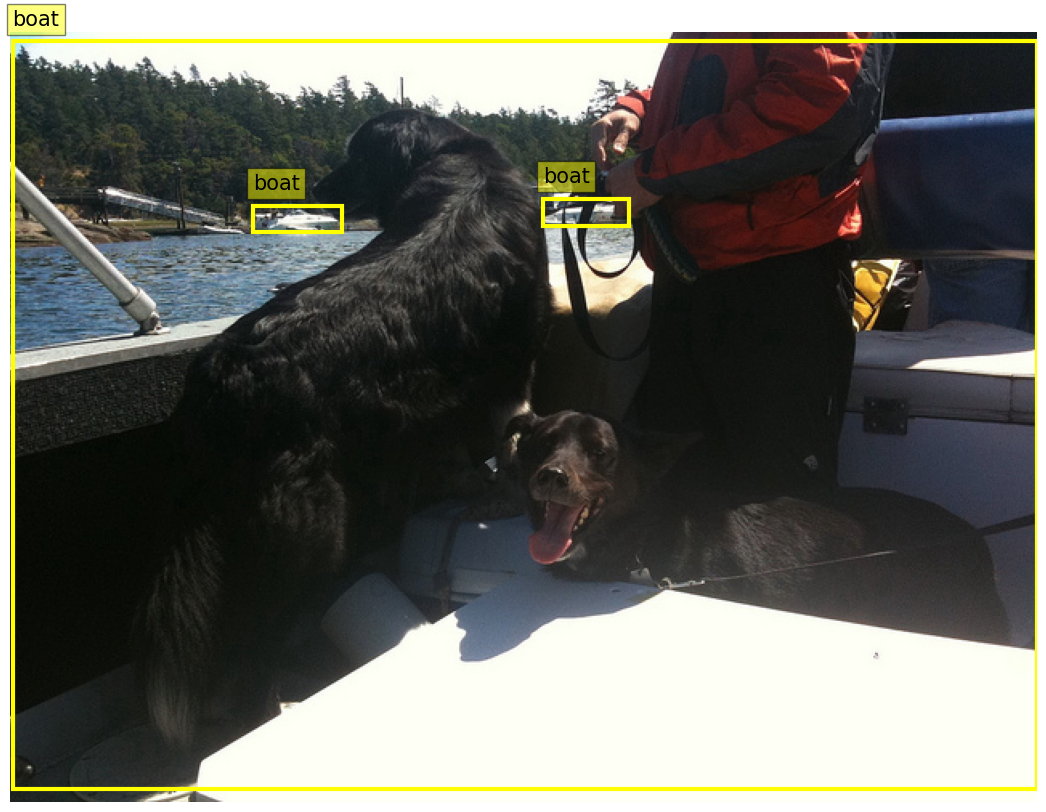

In [28]:
image_idx = 5
display_truth(image_idx)

Image #5 Detected Objects: 
Before NMS: detected 8 objects
After NMS: detected 7 objects


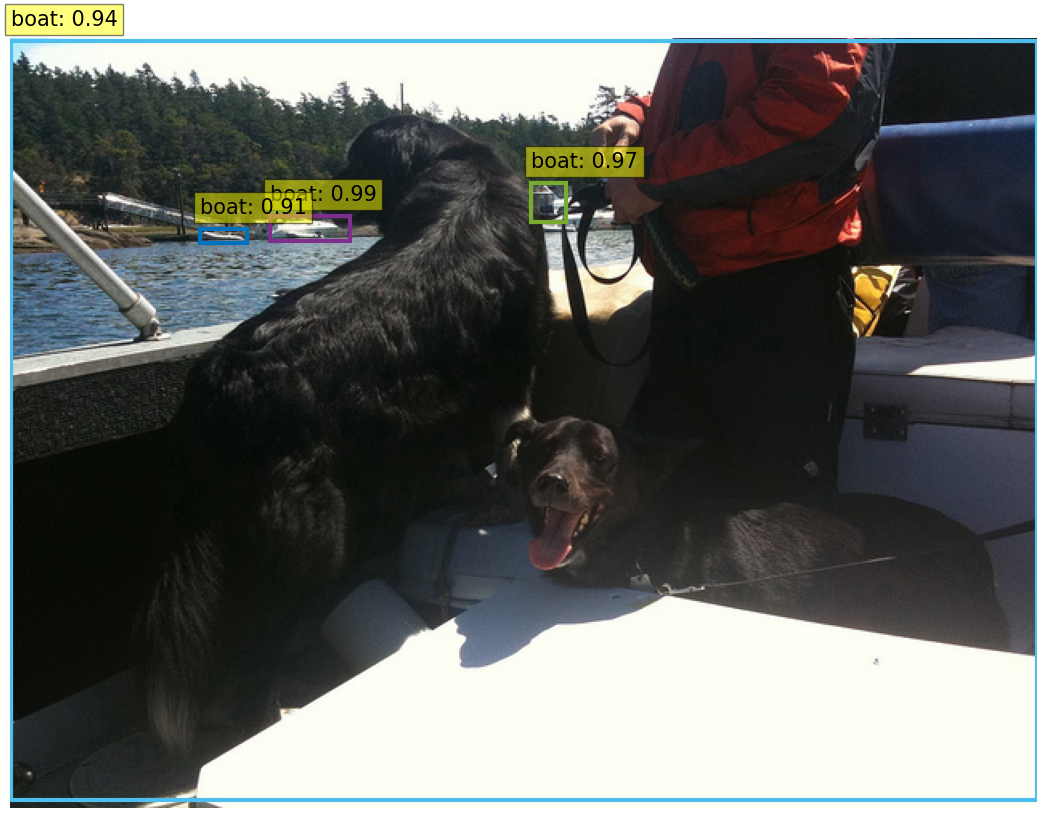

In [29]:
display_inference(pretrained_detr, id2label_coco, image_idx, nms=True)

Image #5 Detected Objects: 
Before NMS: detected 6 objects


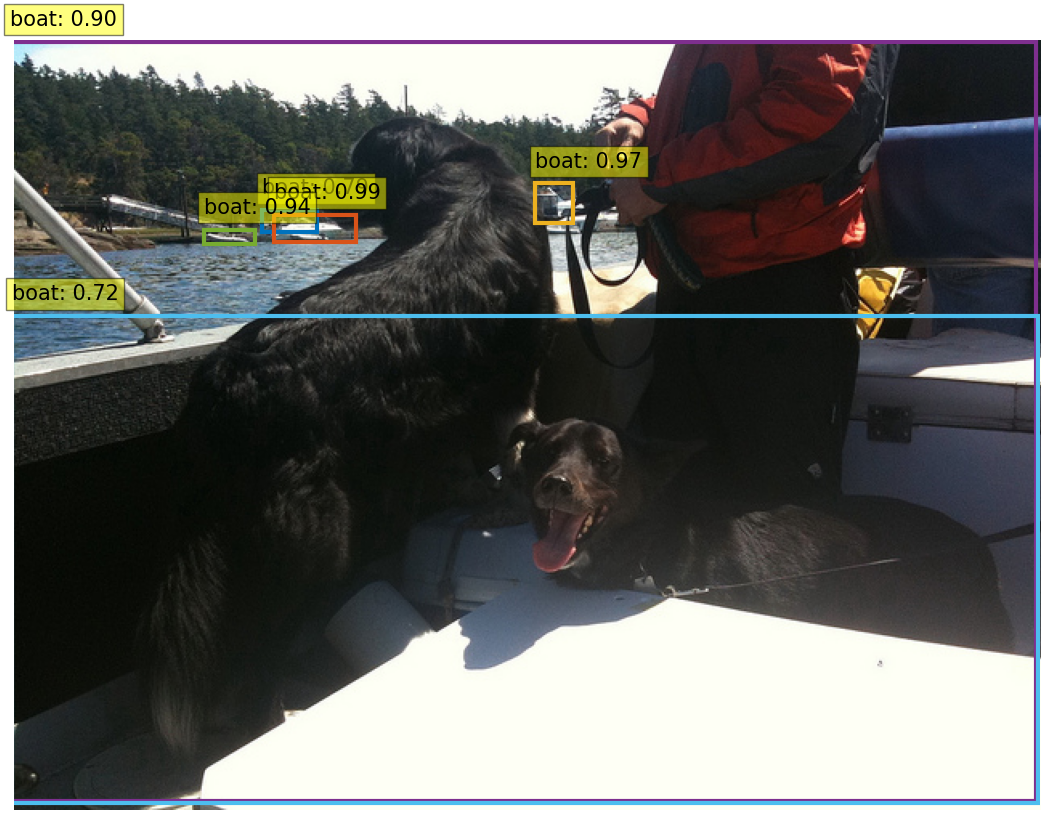

In [36]:
display_inference(my_detr, id2label, image_idx, nms=False)

Image #5 Detected Objects: 
Before NMS: detected 6 objects
After NMS: detected 4 objects


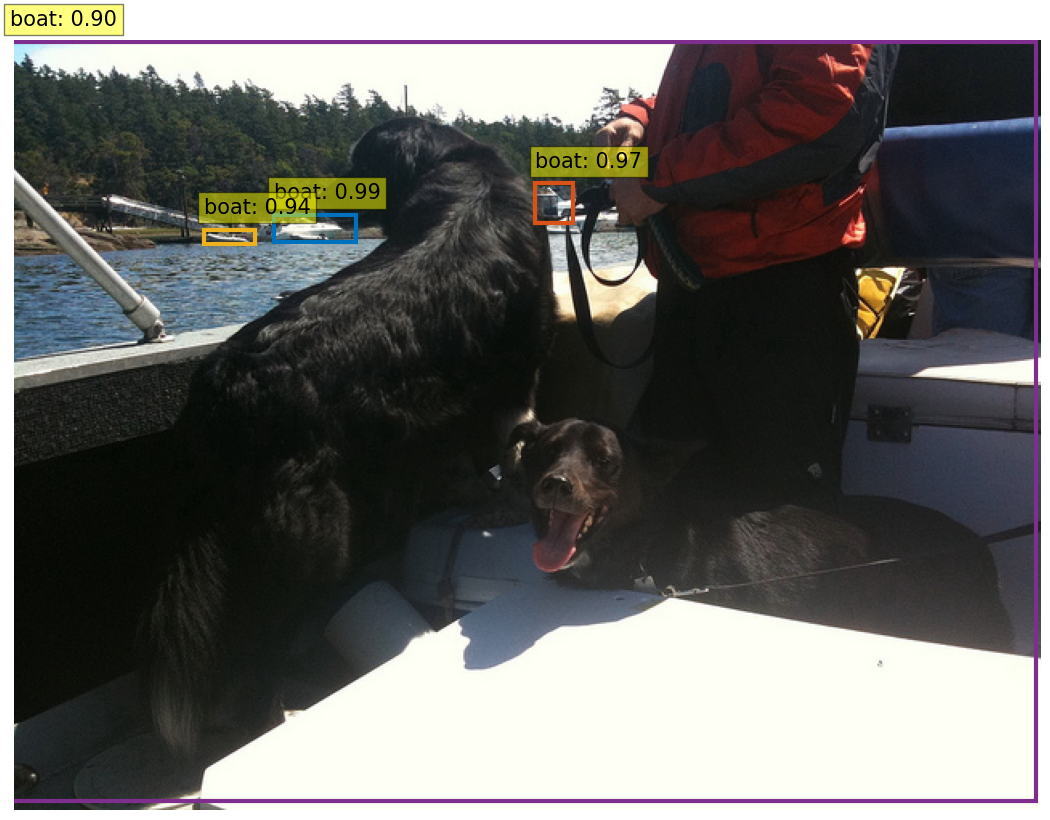

In [42]:
display_inference(my_detr, id2label, image_idx, nms=True)

Image #5 Detected Objects: 
Before NMS: detected 6 objects
After NMS: detected 5 objects


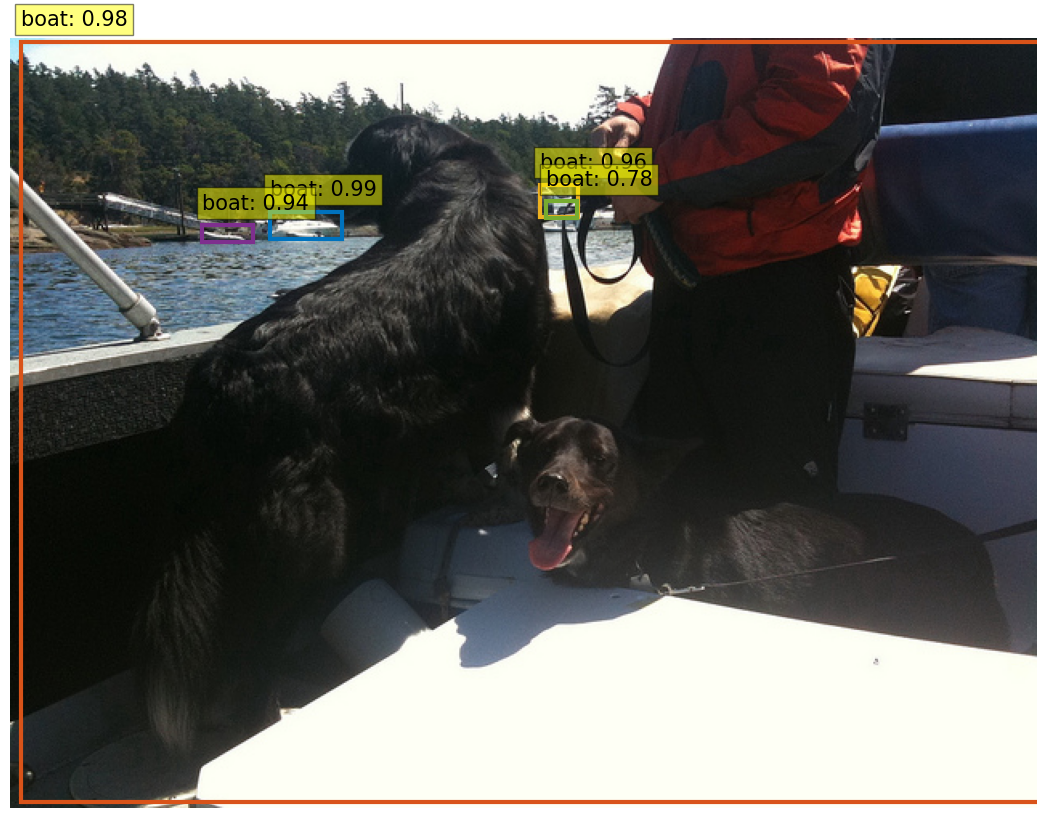

In [55]:
display_inference(my_detr_retrained, id2label, image_idx, nms=True)